# Hyperparameter tuning with Ray Tune

### Setup / Imports

In [1]:
import numpy as np
import pandas as pd

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [2]:
pd.set_option('display.max_columns', None, 'max_colwidth', None, 'display.expand_frame_repr', False)

### Data loaders

In [3]:
class CICIDSDataset(Dataset):
    
    def __init__(self, features_file, target_file, transform=None, target_transform=None):
        self.features = pd.read_pickle(features_file)
        self.labels = pd.read_pickle(target_file)
        self.transform = transform
        self.target_transform = target_transform
           
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature = self.features.iloc[idx, :]
        label = self.labels.iloc[idx, :]
        if self.transform:
            feature = self.transform(feature.values)
        if self.target_transform:
            label = self.target_transform(label.values[0])
        return feature, label


def get_dataset(train_data_path="/Users/othmanebelarbi/Desktop/Toshiba/DBN-FL/datasets/train",
                val_data_path="/Users/othmanebelarbi/Desktop/Toshiba/DBN-FL/datasets/val",
                test_data_path="/Users/othmanebelarbi/Desktop/Toshiba/DBN-FL/datasets/test"):

    train_data = CICIDSDataset(
        features_file=f"{train_data_path}/train_features.pkl",
        target_file=f"{train_data_path}/train_labels.pkl",
        transform=torch.tensor,
        target_transform=torch.tensor
    )

    val_data = CICIDSDataset(
        features_file=f"{val_data_path}/val_features.pkl",
        target_file=f"{val_data_path}/val_labels.pkl",
        transform=torch.tensor,
        target_transform=torch.tensor
    )

    test_data = CICIDSDataset(
        features_file=f"{test_data_path}/test_features.pkl",
        target_file=f"{test_data_path}/test_labels.pkl",
        transform=torch.tensor,
        target_transform=torch.tensor
    )

    return train_data, val_data, test_data

### Configurable neural network
We can only tune those parameters that are configurable. In this example, we can specify the layer sizes of the fully connected layers:

In [4]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, hidden1_size, hidden2_size, num_features=47, num_classes=6):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(num_features, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

### The train function
We wrap the training script in a function `train(config, checkpoint_dir=None, data_dir=None`. As you can guess, the config parameter will receive the hyperparameters we would like to train with. The checkpoint_dir parameter is used to restore checkpoints. The data_dir specifies the directory where we load and store the data, so multiple runs can share the same data source.

In [5]:
def get_samples_weight(target):
    """Get Samples Weight"""
    class_sample_count = np.bincount(target)
    weight = 1. / class_sample_count

    samples_weight = torch.tensor([weight[t] for t in target])
    samples_weigth = samples_weight.double()

    return samples_weight

In [6]:
def train(config, checkpoint_dir=None, data_dir=None):
    net = NeuralNetwork(hidden1_size=config["hidden1_size"],
                        hidden2_size=config["hidden2_size"],
                        hidden3_size=config["hidden3_size"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    train_data, val_data, test_data = get_dataset()
    
    samples_weight = get_samples_weight(train_data.labels['label'])
    sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_data,
        batch_size=int(config["batch_size"]),
        sampler=sampler,
    )
    valid_loader = torch.utils.data.DataLoader(
        dataset=val_data,
        batch_size=int(config["batch_size"]),
        shuffle=True
    )


    for epoch in range(1, 10+1):  # loop over the dataset multiple times
        
        net.train()
        
        train_loss = 0.0
        train_steps = 0
        train_total = 0
        train_correct = 0
        
        epoch_steps = 0
        for i, (inputs, labels) in enumerate(train_loader, 1):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.float())

            loss = criterion(outputs, labels.type(torch.LongTensor))
            loss.backward()
            optimizer.step()
            
            train_loss += loss.cpu().item()
            train_steps += 1
            
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels.type(torch.LongTensor)).sum().item()

        net.eval()
        
        # Validation loss
        val_loss = 0.0
        val_steps = 0
        val_total = 0
        val_correct = 0
        for i, (inputs, labels) in enumerate(valid_loader, 1):
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs.float())
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels.type(torch.LongTensor)).sum().item()

                loss = criterion(outputs, labels.type(torch.LongTensor))
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(train_loss=(train_loss/train_steps),
                    train_accuracy=(train_correct/train_total),
                    val_loss=(val_loss/val_steps),
                    val_accuracy=(val_correct/val_total))
    print("Finished Training")

### Test set accuracy
Commonly the performance of a machine learning model is tested on a hold-out test
set with data that has not been used for training the model. We also wrap this in a
function:

In [7]:
def test_accuracy(net, batch_size, device="cpu"):
    train_data, val_data, test_data = get_dataset()

    test_loader  = torch.utils.data.DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=False
    )

    correct = 0
    total = 0
    with torch.no_grad():
        for (images, labels) in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.type(torch.LongTensor)).sum().item()

    return correct / total

### Configuring the search space

Lastly, we need to define Ray Tune's search space.

At each trial, Ray Tune will now randomly sample a combination of parameters from these search spaces. It will then train a number of models in parallel and find the best performing one among these. We also use the ASHAScheduler which will terminate bad performing trials early.

You can specify the number of CPUs, which are then available e.g. to increase the num_workers of the PyTorch DataLoader instances. The selected number of GPUs are made visible to PyTorch in each trial. Trials do not have access to GPUs that haven't been requested for them - so you don't have to care about two trials using the same set of resources.

Here we can also specify fractional GPUs, so something like gpus_per_trial=0.5 is completely valid. The trials will then share GPUs among each other. You just have to make sure that the models still fit in the GPU memory.
After training the models, we will find the best performing one and load the trained network from the checkpoint file. We then obtain the test set accuracy and report everything by printing.

In [8]:
num_samples=10
max_num_epochs=10

config = {
    "hidden1_size": tune.sample_from(lambda _: 2**np.random.randint(2, 8)),
    "hidden2_size": tune.sample_from(lambda _: 2**np.random.randint(2, 8)),
    "hidden3_size": tune.sample_from(lambda _: 2**np.random.randint(2, 8)),
    "lr": tune.loguniform(1e-3, 1e-1),
    "batch_size": tune.choice([64, 128, 256, 512, 1024])
}
scheduler = ASHAScheduler(
    metric="val_loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=1,
    reduction_factor=2
)
reporter = CLIReporter(metric_columns=["train_loss", "train_accuracy", "val_loss", "val_accuracy", "training_iteration"])
result = tune.run(
    train,
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter
)

best_trial = result.get_best_trial("val_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final training loss: {}".format(
    best_trial.last_result["train_loss"]))
print("Best trial final training accuracy: {}".format(
    best_trial.last_result["train_accuracy"]))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["val_loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["val_accuracy"]))

best_trained_model = NeuralNetwork(best_trial.config["hidden1_size"],
                                   best_trial.config["hidden2_size"],
                                   best_trial.config["hidden3_size"])
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)

best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

test_acc = test_accuracy(best_trained_model, best_trial.config["batch_size"], device)
print("Best trial test set accuracy: {}".format(test_acc))

2021-08-23 17:03:08,221	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-23 17:03:20,918	ERROR syncer.py:72 -- Log sync requires rsync to be installed.


== Status ==
Memory usage on this node: 8.6/15.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects
Result logdir: C:\Users\Othmane Belarbi\ray_results\train_2021-08-23_17-03-20
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------+----------+-------+--------------+----------------+----------------+----------------+------------+
| Trial name        | status   | loc   |   batch_size |   hidden1_size |   hidden2_size |   hidden3_size |         lr |
|-------------------+----------+-------+--------------+----------------+----------------+----------------+------------|
| train_a2f35_00000 | RUNNING  |       |          128 |              4 |             16 |             32 | 0.0499089  |
| train_a2f35_00001 | PENDING  |       |          256 |              4 |              4 |              8 | 0.0146023  |
| train_a2f35_00002 

Result for train_a2f35_00002:
  date: 2021-08-23_17-13-18
  done: true
  experiment_id: cbece570f76d482bbe0c96703bf7084f
  hostname: L393
  iterations_since_restore: 1
  node_ip: 192.168.1.6
  pid: 9948
  should_checkpoint: true
  time_since_restore: 595.7972939014435
  time_this_iter_s: 595.7972939014435
  time_total_s: 595.7972939014435
  timestamp: 1629735198
  timesteps_since_restore: 0
  train_accuracy: 0.8942828350077306
  train_loss: 0.30840701361400835
  training_iteration: 1
  trial_id: a2f35_00002
  val_accuracy: 0.9046758948577668
  val_loss: 0.2898284158516541
  
== Status ==
Memory usage on this node: 12.2/15.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.2665491159463234
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_0_3767a33d9b70034245d77b18d5952e49, 0.0/1.0 CPU_group_0_43cecb8d85b9e4c33b32

(pid=9948) Windows fatal exception: access violation
(pid=9948) 


Result for train_a2f35_00000:
  date: 2021-08-23_17-13-25
  done: false
  experiment_id: aeef0c66e6db4c7db09d400dd14c9c32
  hostname: L393
  iterations_since_restore: 1
  node_ip: 192.168.1.6
  pid: 612
  should_checkpoint: true
  time_since_restore: 602.7933554649353
  time_this_iter_s: 602.7933554649353
  time_total_s: 602.7933554649353
  timestamp: 1629735205
  timesteps_since_restore: 0
  train_accuracy: 0.95564243700442
  train_loss: 0.13657902757139406
  training_iteration: 1
  trial_id: a2f35_00000
  val_accuracy: 0.9204199319828479
  val_loss: 0.23427992271587492
  
== Status ==
Memory usage on this node: 10.9/15.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.24326981604099274
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_0_3767a33d9b70034245d77b18d5952e49, 0.0/1.0 CPU_group_0_43cecb8d85b9e4c33b32

Result for train_a2f35_00003:
  date: 2021-08-23_17-23-29
  done: false
  experiment_id: 38428ac58bcd402f9774b40933b4045c
  hostname: L393
  iterations_since_restore: 2
  node_ip: 192.168.1.6
  pid: 14092
  should_checkpoint: true
  time_since_restore: 1206.3370978832245
  time_this_iter_s: 603.2534031867981
  time_total_s: 1206.3370978832245
  timestamp: 1629735809
  timesteps_since_restore: 0
  train_accuracy: 0.98168766203386
  train_loss: 0.056937766540506335
  training_iteration: 2
  trial_id: a2f35_00003
  val_accuracy: 0.9403519148306965
  val_loss: 0.1533228322490616
  
== Status ==
Memory usage on this node: 9.5/15.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.211188872820753 | Iter 1.000: -0.2407037886846225
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_0_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_0_8a1a

(pid=612) Windows fatal exception: access violation
(pid=612) 
2021-08-23 17:23:29,730	WARNING worker.py:1189 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. Task ID: ffffffffffffffffdaaf882e2fb7af0802ecc8a201000000 Worker ID: b8071898cc856f9fa1d22ceb9c219640f9d362ed027abc88084ccd13 Node ID: 1ab35fae20787fff1b71175f821f5b1bab74a36bca5f057e0c494a7c Worker IP address: 192.168.1.6 Worker port: 49964 Worker PID: 612


Result for train_a2f35_00004:
  date: 2021-08-23_17-23-34
  done: false
  experiment_id: ac0d2d100d8e45adb194aaafb0d812b5
  hostname: L393
  iterations_since_restore: 1
  node_ip: 192.168.1.6
  pid: 3016
  should_checkpoint: true
  time_since_restore: 600.3561699390411
  time_this_iter_s: 600.3561699390411
  time_total_s: 600.3561699390411
  timestamp: 1629735814
  timesteps_since_restore: 0
  train_accuracy: 0.9666867103989056
  train_loss: 0.09881053740243277
  training_iteration: 1
  trial_id: a2f35_00004
  val_accuracy: 0.9407204358557308
  val_loss: 0.15801371321324975
  
Result for train_a2f35_00001:
  date: 2021-08-23_17-32-51
  done: false
  experiment_id: 01f8f04d952442d49fe3ef96f6f8bc91
  hostname: L393
  iterations_since_restore: 3
  node_ip: 192.168.1.6
  pid: 9276
  should_checkpoint: true
  time_since_restore: 1768.2465925216675
  time_this_iter_s: 587.1049435138702
  time_total_s: 1768.2465925216675
  timestamp: 1629736371
  timesteps_since_restore: 0
  train_accuracy: 0

Result for train_a2f35_00004:
  date: 2021-08-23_17-33-30
  done: false
  experiment_id: ac0d2d100d8e45adb194aaafb0d812b5
  hostname: L393
  iterations_since_restore: 2
  node_ip: 192.168.1.6
  pid: 3016
  should_checkpoint: true
  time_since_restore: 1196.518259048462
  time_this_iter_s: 596.1620891094208
  time_total_s: 1196.518259048462
  timestamp: 1629736410
  timesteps_since_restore: 0
  train_accuracy: 0.9809460692168461
  train_loss: 0.05649077690266845
  training_iteration: 2
  trial_id: a2f35_00004
  val_accuracy: 0.9437345738691295
  val_loss: 0.1365760621659206
  
Result for train_a2f35_00005:
  date: 2021-08-23_17-34-00
  done: false
  experiment_id: 72b00c472da742208d1ddccfd2313b7a
  hostname: L393
  iterations_since_restore: 1
  node_ip: 192.168.1.6
  pid: 15476
  should_checkpoint: true
  time_since_restore: 620.5511164665222
  time_this_iter_s: 620.5511164665222
  time_total_s: 620.5511164665222
  timestamp: 1629736440
  timesteps_since_restore: 0
  train_accuracy: 0.9

Result for train_a2f35_00004:
  date: 2021-08-23_17-43-26
  done: false
  experiment_id: ac0d2d100d8e45adb194aaafb0d812b5
  hostname: L393
  iterations_since_restore: 3
  node_ip: 192.168.1.6
  pid: 3016
  should_checkpoint: true
  time_since_restore: 1792.8272151947021
  time_this_iter_s: 596.3089561462402
  time_total_s: 1792.8272151947021
  timestamp: 1629737006
  timesteps_since_restore: 0
  train_accuracy: 0.9840815357795786
  train_loss: 0.046929618354105126
  training_iteration: 3
  trial_id: a2f35_00004
  val_accuracy: 0.9440712473981733
  val_loss: 0.15883438842538072
  
== Status ==
Memory usage on this node: 9.5/15.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: None | Iter 4.000: -0.21918303773188758 | Iter 2.000: -0.18480498230679088 | Iter 1.000: -0.2362088420220636
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_0_8a1a9e65a29d46ac7d5be6a7c500174f, 0.0/

Result for train_a2f35_00005:
  date: 2021-08-23_17-44-20
  done: true
  experiment_id: 72b00c472da742208d1ddccfd2313b7a
  hostname: L393
  iterations_since_restore: 2
  node_ip: 192.168.1.6
  pid: 15476
  should_checkpoint: true
  time_since_restore: 1240.987830877304
  time_this_iter_s: 620.4367144107819
  time_total_s: 1240.987830877304
  timestamp: 1629737060
  timesteps_since_restore: 0
  train_accuracy: 0.9803447572496764
  train_loss: 0.059317414317824606
  training_iteration: 2
  trial_id: a2f35_00005
  val_accuracy: 0.925306247796267
  val_loss: 0.23377677807768799
  
== Status ==
Memory usage on this node: 9.3/15.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: None | Iter 4.000: -0.15839596927367644 | Iter 2.000: -0.21628713236452016 | Iter 1.000: -0.2362088420220636
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_0_3767a33d9b70034245d77b18d5952e49, 0.0/1.0

(pid=15476) Windows fatal exception: access violation
(pid=15476) 
2021-08-23 17:44:22,284	WARNING worker.py:1189 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. Task ID: fffffffffffffffffa8be2cd8a4d04794740d91301000000 Worker ID: 2d72d52964f6c75883a648ff9be4005b917155770c3b5fab0cf5cbea Node ID: 1ab35fae20787fff1b71175f821f5b1bab74a36bca5f057e0c494a7c Worker IP address: 192.168.1.6 Worker port: 52965 Worker PID: 15476


Result for train_a2f35_00001:
  date: 2021-08-23_17-52-24
  done: false
  experiment_id: 01f8f04d952442d49fe3ef96f6f8bc91
  hostname: L393
  iterations_since_restore: 5
  node_ip: 192.168.1.6
  pid: 9276
  should_checkpoint: true
  time_since_restore: 2941.9427003860474
  time_this_iter_s: 586.4553339481354
  time_total_s: 2941.9427003860474
  timestamp: 1629737544
  timesteps_since_restore: 0
  train_accuracy: 0.9733837939979512
  train_loss: 0.08556984569038617
  training_iteration: 5
  trial_id: a2f35_00001
  val_accuracy: 0.933595696038399
  val_loss: 0.18107135108605946
  
== Status ==
Memory usage on this node: 9.1/15.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: None | Iter 4.000: -0.15839596927367644 | Iter 2.000: -0.21628713236452016 | Iter 1.000: -0.2362088420220636
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_0_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.

Result for train_a2f35_00003:
  date: 2021-08-23_17-53-30
  done: false
  experiment_id: 38428ac58bcd402f9774b40933b4045c
  hostname: L393
  iterations_since_restore: 5
  node_ip: 192.168.1.6
  pid: 14092
  should_checkpoint: true
  time_since_restore: 3007.901987552643
  time_this_iter_s: 598.5185358524323
  time_total_s: 3007.901987552643
  timestamp: 1629737610
  timesteps_since_restore: 0
  train_accuracy: 0.9892537286270752
  train_loss: 0.03301596727934615
  training_iteration: 5
  trial_id: a2f35_00003
  val_accuracy: 0.9767695264959793
  val_loss: 0.05670507867469282
  
== Status ==
Memory usage on this node: 9.2/15.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: None | Iter 4.000: -0.11786030116138657 | Iter 2.000: -0.21628713236452016 | Iter 1.000: -0.2362088420220636
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_0_3767a33d9b70034245d77b18d5952e49, 0.0/1.

Result for train_a2f35_00001:
  date: 2021-08-23_18-02-12
  done: false
  experiment_id: 01f8f04d952442d49fe3ef96f6f8bc91
  hostname: L393
  iterations_since_restore: 6
  node_ip: 192.168.1.6
  pid: 9276
  should_checkpoint: true
  time_since_restore: 3530.0362989902496
  time_this_iter_s: 588.0935986042023
  time_total_s: 3530.0362989902496
  timestamp: 1629738132
  timesteps_since_restore: 0
  train_accuracy: 0.9749625222648457
  train_loss: 0.08059853758689693
  training_iteration: 6
  trial_id: a2f35_00001
  val_accuracy: 0.956343907460276
  val_loss: 0.15926271517423868
  
== Status ==
Memory usage on this node: 9.2/15.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: None | Iter 4.000: -0.11786030116138657 | Iter 2.000: -0.21628713236452016 | Iter 1.000: -0.23427992271587492
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_0_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1

Result for train_a2f35_00003:
  date: 2021-08-23_18-03-32
  done: false
  experiment_id: 38428ac58bcd402f9774b40933b4045c
  hostname: L393
  iterations_since_restore: 6
  node_ip: 192.168.1.6
  pid: 14092
  should_checkpoint: true
  time_since_restore: 3609.8251864910126
  time_this_iter_s: 601.9231989383698
  time_total_s: 3609.8251864910126
  timestamp: 1629738212
  timesteps_since_restore: 0
  train_accuracy: 0.9910690386515446
  train_loss: 0.028063645443337844
  training_iteration: 6
  trial_id: a2f35_00003
  val_accuracy: 0.9731366371319055
  val_loss: 0.06699392410825691
  
== Status ==
Memory usage on this node: 9.3/15.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: None | Iter 4.000: -0.11786030116138657 | Iter 2.000: -0.21628713236452016 | Iter 1.000: -0.23427992271587492
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_0_3767a33d9b70034245d77b18d5952e49, 0.

Result for train_a2f35_00001:
  date: 2021-08-23_18-12-01
  done: false
  experiment_id: 01f8f04d952442d49fe3ef96f6f8bc91
  hostname: L393
  iterations_since_restore: 7
  node_ip: 192.168.1.6
  pid: 9276
  should_checkpoint: true
  time_since_restore: 4119.00810956955
  time_this_iter_s: 588.9718105792999
  time_total_s: 4119.00810956955
  timestamp: 1629738721
  timesteps_since_restore: 0
  train_accuracy: 0.9762485564342276
  train_loss: 0.07778193512320467
  training_iteration: 7
  trial_id: a2f35_00001
  val_accuracy: 0.9396307965286229
  val_loss: 0.19865518188422787
  
== Status ==
Memory usage on this node: 8.4/15.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: None | Iter 4.000: -0.11786030116138657 | Iter 2.000: -0.18480498230679088 | Iter 1.000: -0.23427992271587492
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_0_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 

Result for train_a2f35_00003:
  date: 2021-08-23_18-13-33
  done: false
  experiment_id: 38428ac58bcd402f9774b40933b4045c
  hostname: L393
  iterations_since_restore: 7
  node_ip: 192.168.1.6
  pid: 14092
  should_checkpoint: true
  time_since_restore: 4210.735874414444
  time_this_iter_s: 600.9106879234314
  time_total_s: 4210.735874414444
  timestamp: 1629738813
  timesteps_since_restore: 0
  train_accuracy: 0.991997167085108
  train_loss: 0.024941557707562022
  training_iteration: 7
  trial_id: a2f35_00003
  val_accuracy: 0.9683754364813066
  val_loss: 0.09011255443633921
  
== Status ==
Memory usage on this node: 8.5/15.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: None | Iter 4.000: -0.11786030116138657 | Iter 2.000: -0.18480498230679088 | Iter 1.000: -0.23427992271587492
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_0_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1

Result for train_a2f35_00001:
  date: 2021-08-23_18-21-49
  done: false
  experiment_id: 01f8f04d952442d49fe3ef96f6f8bc91
  hostname: L393
  iterations_since_restore: 8
  node_ip: 192.168.1.6
  pid: 9276
  should_checkpoint: true
  time_since_restore: 4706.247946023941
  time_this_iter_s: 587.2398364543915
  time_total_s: 4706.247946023941
  timestamp: 1629739309
  timesteps_since_restore: 0
  train_accuracy: 0.9770174471463463
  train_loss: 0.076103516480696
  training_iteration: 8
  trial_id: a2f35_00001
  val_accuracy: 0.9534412356828444
  val_loss: 0.14481464936479285
  
== Status ==
Memory usage on this node: 8.5/15.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.14481464936479285 | Iter 4.000: -0.11786030116138657 | Iter 2.000: -0.18480498230679088 | Iter 1.000: -0.23427992271587492
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_0_3767a33d9b70034245d77b18d5

Result for train_a2f35_00003:
  date: 2021-08-23_18-23-33
  done: false
  experiment_id: 38428ac58bcd402f9774b40933b4045c
  hostname: L393
  iterations_since_restore: 8
  node_ip: 192.168.1.6
  pid: 14092
  should_checkpoint: true
  time_since_restore: 4810.314200162888
  time_this_iter_s: 599.5783257484436
  time_total_s: 4810.314200162888
  timestamp: 1629739413
  timesteps_since_restore: 0
  train_accuracy: 0.9933666114895324
  train_loss: 0.021016588992792073
  training_iteration: 8
  trial_id: a2f35_00003
  val_accuracy: 0.9702157667853365
  val_loss: 0.07541717555399928
  
== Status ==
Memory usage on this node: 8.5/15.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.11011591245939606 | Iter 4.000: -0.11786030116138657 | Iter 2.000: -0.18480498230679088 | Iter 1.000: -0.23427992271587492
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_0_3767a33d9b70034245d77b

Result for train_a2f35_00001:
  date: 2021-08-23_18-31-36
  done: false
  experiment_id: 01f8f04d952442d49fe3ef96f6f8bc91
  hostname: L393
  iterations_since_restore: 9
  node_ip: 192.168.1.6
  pid: 9276
  should_checkpoint: true
  time_since_restore: 5293.812045812607
  time_this_iter_s: 587.5640997886658
  time_total_s: 5293.812045812607
  timestamp: 1629739896
  timesteps_since_restore: 0
  train_accuracy: 0.9778363839994905
  train_loss: 0.07243574328915077
  training_iteration: 9
  trial_id: a2f35_00001
  val_accuracy: 0.9161296193086819
  val_loss: 0.2609862697389892
  
== Status ==
Memory usage on this node: 8.4/15.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.11011591245939606 | Iter 4.000: -0.10773460098842595 | Iter 2.000: -0.18480498230679088 | Iter 1.000: -0.23427992271587492
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_0_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a

Result for train_a2f35_00003:
  date: 2021-08-23_18-33-34
  done: false
  experiment_id: 38428ac58bcd402f9774b40933b4045c
  hostname: L393
  iterations_since_restore: 9
  node_ip: 192.168.1.6
  pid: 14092
  should_checkpoint: true
  time_since_restore: 5411.481922388077
  time_this_iter_s: 601.1677222251892
  time_total_s: 5411.481922388077
  timestamp: 1629740014
  timesteps_since_restore: 0
  train_accuracy: 0.9942462103317984
  train_loss: 0.018851431898346736
  training_iteration: 9
  trial_id: a2f35_00003
  val_accuracy: 0.9740169929139322
  val_loss: 0.07498904588178008
  
== Status ==
Memory usage on this node: 8.4/15.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.07541717555399928 | Iter 4.000: -0.10773460098842595 | Iter 2.000: -0.18480498230679088 | Iter 1.000: -0.23427992271587492
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_0_3767a33d9b70034245d77b

Result for train_a2f35_00001:
  date: 2021-08-23_18-41-25
  done: true
  experiment_id: 01f8f04d952442d49fe3ef96f6f8bc91
  hostname: L393
  iterations_since_restore: 10
  node_ip: 192.168.1.6
  pid: 9276
  should_checkpoint: true
  time_since_restore: 5882.1452605724335
  time_this_iter_s: 588.3332147598267
  time_total_s: 5882.1452605724335
  timestamp: 1629740485
  timesteps_since_restore: 0
  train_accuracy: 0.9776574311315812
  train_loss: 0.07383363170824765
  training_iteration: 10
  trial_id: a2f35_00001
  val_accuracy: 0.9309705524403143
  val_loss: 0.20524665671243517
  
== Status ==
Memory usage on this node: 8.5/15.9 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.07541717555399928 | Iter 4.000: -0.10773460098842595 | Iter 2.000: -0.18480498230679088 | Iter 1.000: -0.23427992271587492
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_0_3767a33d9b70034245d77

(pid=9276) Windows fatal exception: access violation
(pid=9276) 


Result for train_a2f35_00004:
  date: 2021-08-23_18-43-07
  done: false
  experiment_id: ac0d2d100d8e45adb194aaafb0d812b5
  hostname: L393
  iterations_since_restore: 9
  node_ip: 192.168.1.6
  pid: 3016
  should_checkpoint: true
  time_since_restore: 5374.04750752449
  time_this_iter_s: 597.2643029689789
  time_total_s: 5374.04750752449
  timestamp: 1629740587
  timesteps_since_restore: 0
  train_accuracy: 0.9890914578061744
  train_loss: 0.03375509833078117
  training_iteration: 9
  trial_id: a2f35_00004
  val_accuracy: 0.9631433478542749
  val_loss: 0.0940768040252613
  
== Status ==
Memory usage on this node: 9.3/15.9 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.07541717555399928 | Iter 4.000: -0.10773460098842595 | Iter 2.000: -0.18480498230679088 | Iter 1.000: -0.23427992271587492
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_0_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10

(pid=14092) Windows fatal exception: access violation
(pid=14092) 


Result for train_a2f35_00006:
  date: 2021-08-23_18-43-58
  done: false
  experiment_id: 9b4361c48840419d8b8f41361c200fdf
  hostname: L393
  iterations_since_restore: 6
  node_ip: 192.168.1.6
  pid: 13060
  should_checkpoint: true
  time_since_restore: 3567.402356863022
  time_this_iter_s: 595.3519082069397
  time_total_s: 3567.402356863022
  timestamp: 1629740638
  timesteps_since_restore: 0
  train_accuracy: 0.9867157826571923
  train_loss: 0.041305759803582524
  training_iteration: 6
  trial_id: a2f35_00006
  val_accuracy: 0.9702498891024693
  val_loss: 0.07451774809093185
  
== Status ==
Memory usage on this node: 10.1/15.9 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: -0.07541717555399928 | Iter 4.000: -0.10773460098842595 | Iter 2.000: -0.18480498230679088 | Iter 1.000: -0.23427992271587492
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_0_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_43cecb8d85b9e4c33b329

(pid=8468) Windows fatal exception: access violation
(pid=8468) 
2021-08-23 18:52:19,543	WARNING worker.py:1189 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. Task ID: ffffffffffffffff353d3f04e50378a9b39b9ac601000000 Worker ID: a31783bacd7be395ae49f5636ab0e9fe3e02bb5463affda8b336e78b Node ID: 1ab35fae20787fff1b71175f821f5b1bab74a36bca5f057e0c494a7c Worker IP address: 192.168.1.6 Worker port: 61373 Worker PID: 8468


Result for train_a2f35_00004:
  date: 2021-08-23_18-53-14
  done: true
  experiment_id: ac0d2d100d8e45adb194aaafb0d812b5
  hostname: L393
  iterations_since_restore: 10
  node_ip: 192.168.1.6
  pid: 3016
  should_checkpoint: true
  time_since_restore: 5980.612647294998
  time_this_iter_s: 606.5651397705078
  time_total_s: 5980.612647294998
  timestamp: 1629741194
  timesteps_since_restore: 0
  train_accuracy: 0.9882164086130926
  train_loss: 0.03469219761505623
  training_iteration: 10
  trial_id: a2f35_00004
  val_accuracy: 0.9669468488040128
  val_loss: 0.09696541456624917
  
== Status ==
Memory usage on this node: 10.0/15.9 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.07541717555399928 | Iter 4.000: -0.10773460098842595 | Iter 2.000: -0.18480498230679088 | Iter 1.000: -0.2362088420220636
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_0_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_43cecb8d85b9e4c33b32988

(pid=3016) Windows fatal exception: access violation
(pid=3016) 


Result for train_a2f35_00008:
  date: 2021-08-23_18-53-42
  done: false
  experiment_id: d92d1dda617c451f9f9d1b1f9c8a9a7e
  hostname: L393
  iterations_since_restore: 1
  node_ip: 192.168.1.6
  pid: 7700
  should_checkpoint: true
  time_since_restore: 597.3294477462769
  time_this_iter_s: 597.3294477462769
  time_total_s: 597.3294477462769
  timestamp: 1629741222
  timesteps_since_restore: 0
  train_accuracy: 0.963476174624635
  train_loss: 0.11130538920803944
  training_iteration: 1
  trial_id: a2f35_00008
  val_accuracy: 0.945001649245328
  val_loss: 0.15086187354621844
  
== Status ==
Memory usage on this node: 9.9/15.9 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.07541717555399928 | Iter 4.000: -0.10773460098842595 | Iter 2.000: -0.18480498230679088 | Iter 1.000: -0.23427992271587492
Resources requested: 3.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_0_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a1

Result for train_a2f35_00009:
  date: 2021-08-23_19-00-52
  done: false
  experiment_id: 811e79f6ea8c4d1c98ce68a7acd24fc2
  hostname: L393
  iterations_since_restore: 1
  node_ip: 192.168.1.6
  pid: 2352
  should_checkpoint: true
  time_since_restore: 502.7272620201111
  time_this_iter_s: 502.7272620201111
  time_total_s: 502.7272620201111
  timestamp: 1629741652
  timesteps_since_restore: 0
  train_accuracy: 0.964563540779643
  train_loss: 0.09878634367885972
  training_iteration: 1
  trial_id: a2f35_00009
  val_accuracy: 0.9212434172363198
  val_loss: 0.19356559224215267
  
== Status ==
Memory usage on this node: 9.8/15.9 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.07541717555399928 | Iter 4.000: -0.10773460098842595 | Iter 2.000: -0.18480498230679088 | Iter 1.000: -0.21904605800958454
Resources requested: 3.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_83c22d34d4a835eed0d4a70ec85

Result for train_a2f35_00006:
  date: 2021-08-23_19-02-01
  done: true
  experiment_id: 9b4361c48840419d8b8f41361c200fdf
  hostname: L393
  iterations_since_restore: 8
  node_ip: 192.168.1.6
  pid: 13060
  should_checkpoint: true
  time_since_restore: 4650.2409036159515
  time_this_iter_s: 485.2382905483246
  time_total_s: 4650.2409036159515
  timestamp: 1629741721
  timesteps_since_restore: 0
  train_accuracy: 0.989081600232942
  train_loss: 0.03328256341521173
  training_iteration: 8
  trial_id: a2f35_00006
  val_accuracy: 0.9604863567601998
  val_loss: 0.09366714947979476
  
== Status ==
Memory usage on this node: 8.3/15.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.08454216251689703 | Iter 4.000: -0.10773460098842595 | Iter 2.000: -0.1533228322490616 | Iter 1.000: -0.21904605800958454
Resources requested: 3.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_83c22d34d4a835eed0d4a70ec8

(pid=13060) Windows fatal exception: access violation
(pid=13060) 


Result for train_a2f35_00009:
  date: 2021-08-23_19-08-13
  done: false
  experiment_id: 811e79f6ea8c4d1c98ce68a7acd24fc2
  hostname: L393
  iterations_since_restore: 2
  node_ip: 192.168.1.6
  pid: 2352
  should_checkpoint: true
  time_since_restore: 943.8422737121582
  time_this_iter_s: 441.1150116920471
  time_total_s: 943.8422737121582
  timestamp: 1629742093
  timesteps_since_restore: 0
  train_accuracy: 0.9827075417259701
  train_loss: 0.050910461250069164
  training_iteration: 2
  trial_id: a2f35_00009
  val_accuracy: 0.9385479816649416
  val_loss: 0.15227000418470243
  
== Status ==
Memory usage on this node: 8.2/15.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.08454216251689703 | Iter 4.000: -0.10773460098842595 | Iter 2.000: -0.152796418216882 | Iter 1.000: -0.21904605800958454
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_83c22d34d4a835eed0d4a70ec85

Result for train_a2f35_00009:
  date: 2021-08-23_19-15-25
  done: false
  experiment_id: 811e79f6ea8c4d1c98ce68a7acd24fc2
  hostname: L393
  iterations_since_restore: 3
  node_ip: 192.168.1.6
  pid: 2352
  should_checkpoint: true
  time_since_restore: 1376.0347669124603
  time_this_iter_s: 432.1924932003021
  time_total_s: 1376.0347669124603
  timestamp: 1629742525
  timesteps_since_restore: 0
  train_accuracy: 0.9842953692912328
  train_loss: 0.04620267847233988
  training_iteration: 3
  trial_id: a2f35_00009
  val_accuracy: 0.9684118336195816
  val_loss: 0.09541754083242945
  
== Status ==
Memory usage on this node: 8.1/15.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.08454216251689703 | Iter 4.000: -0.10773460098842595 | Iter 2.000: -0.152796418216882 | Iter 1.000: -0.21904605800958454
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_83c22d34d4a835eed0d4a70ec8

Result for train_a2f35_00009:
  date: 2021-08-23_19-22-37
  done: false
  experiment_id: 811e79f6ea8c4d1c98ce68a7acd24fc2
  hostname: L393
  iterations_since_restore: 4
  node_ip: 192.168.1.6
  pid: 2352
  should_checkpoint: true
  time_since_restore: 1808.1872670650482
  time_this_iter_s: 432.1525001525879
  time_total_s: 1808.1872670650482
  timestamp: 1629742957
  timesteps_since_restore: 0
  train_accuracy: 0.9864716181509771
  train_loss: 0.041581778521986704
  training_iteration: 4
  trial_id: a2f35_00009
  val_accuracy: 0.9629477132360468
  val_loss: 0.08227850577544578
  
== Status ==
Memory usage on this node: 8.1/15.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.08454216251689703 | Iter 4.000: -0.08994370329545556 | Iter 2.000: -0.152796418216882 | Iter 1.000: -0.21904605800958454
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_83c22d34d4a835eed0d4a70ec

Result for train_a2f35_00009:
  date: 2021-08-23_19-29-50
  done: false
  experiment_id: 811e79f6ea8c4d1c98ce68a7acd24fc2
  hostname: L393
  iterations_since_restore: 5
  node_ip: 192.168.1.6
  pid: 2352
  should_checkpoint: true
  time_since_restore: 2241.0171825885773
  time_this_iter_s: 432.82991552352905
  time_total_s: 2241.0171825885773
  timestamp: 1629743390
  timesteps_since_restore: 0
  train_accuracy: 0.9874960474922713
  train_loss: 0.03790479325639207
  training_iteration: 5
  trial_id: a2f35_00009
  val_accuracy: 0.9695788168655239
  val_loss: 0.07119289760595103
  
== Status ==
Memory usage on this node: 8.1/15.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.08454216251689703 | Iter 4.000: -0.08994370329545556 | Iter 2.000: -0.152796418216882 | Iter 1.000: -0.21904605800958454
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_0_83c22d34d4a835eed0d4a70ec852a6f4, 0.0/1.0 CPU_group_43cecb8d85b9e4c33b32988

Result for train_a2f35_00009:
  date: 2021-08-23_19-37-02
  done: false
  experiment_id: 811e79f6ea8c4d1c98ce68a7acd24fc2
  hostname: L393
  iterations_since_restore: 6
  node_ip: 192.168.1.6
  pid: 2352
  should_checkpoint: true
  time_since_restore: 2673.6334953308105
  time_this_iter_s: 432.6163127422333
  time_total_s: 2673.6334953308105
  timestamp: 1629743822
  timesteps_since_restore: 0
  train_accuracy: 0.9883134677956874
  train_loss: 0.035488612092297867
  training_iteration: 6
  trial_id: a2f35_00009
  val_accuracy: 0.9644786678647391
  val_loss: 0.08027317408435697
  
== Status ==
Memory usage on this node: 8.1/15.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.08454216251689703 | Iter 4.000: -0.08994370329545556 | Iter 2.000: -0.152796418216882 | Iter 1.000: -0.21904605800958454
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_0_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_43cecb8d85b9e4c33b32988

Result for train_a2f35_00009:
  date: 2021-08-23_19-44-19
  done: false
  experiment_id: 811e79f6ea8c4d1c98ce68a7acd24fc2
  hostname: L393
  iterations_since_restore: 7
  node_ip: 192.168.1.6
  pid: 2352
  should_checkpoint: true
  time_since_restore: 3109.797912120819
  time_this_iter_s: 436.16441679000854
  time_total_s: 3109.797912120819
  timestamp: 1629744259
  timesteps_since_restore: 0
  train_accuracy: 0.9890292792673245
  train_loss: 0.034095991237597184
  training_iteration: 7
  trial_id: a2f35_00009
  val_accuracy: 0.9685801703841036
  val_loss: 0.0777155289579633
  
== Status ==
Memory usage on this node: 8.3/15.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.07541717555399928 | Iter 4.000: -0.08994370329545556 | Iter 2.000: -0.152796418216882 | Iter 1.000: -0.21904605800958454
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_0_83c22d34d4a835eed0d4a70ec852a6f4, 0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a

Result for train_a2f35_00009:
  date: 2021-08-23_19-51-33
  done: false
  experiment_id: 811e79f6ea8c4d1c98ce68a7acd24fc2
  hostname: L393
  iterations_since_restore: 8
  node_ip: 192.168.1.6
  pid: 2352
  should_checkpoint: true
  time_since_restore: 3543.7502183914185
  time_this_iter_s: 433.95230627059937
  time_total_s: 3543.7502183914185
  timestamp: 1629744693
  timesteps_since_restore: 0
  train_accuracy: 0.9896495481060947
  train_loss: 0.03134724706046105
  training_iteration: 8
  trial_id: a2f35_00009
  val_accuracy: 0.9741580318247478
  val_loss: 0.06179896024604134
  
== Status ==
Memory usage on this node: 8.3/15.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.07457845462529517 | Iter 4.000: -0.08994370329545556 | Iter 2.000: -0.152796418216882 | Iter 1.000: -0.21904605800958454
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_83c22d34d4a835eed0d4a70ec

(pid=7700) Windows fatal exception: access violation
(pid=7700) 


Result for train_a2f35_00009:
  date: 2021-08-23_19-58-42
  done: false
  experiment_id: 811e79f6ea8c4d1c98ce68a7acd24fc2
  hostname: L393
  iterations_since_restore: 9
  node_ip: 192.168.1.6
  pid: 2352
  should_checkpoint: true
  time_since_restore: 3972.676771402359
  time_this_iter_s: 428.92655301094055
  time_total_s: 3972.676771402359
  timestamp: 1629745122
  timesteps_since_restore: 0
  train_accuracy: 0.991044015581032
  train_loss: 0.027646284877539288
  training_iteration: 9
  trial_id: a2f35_00009
  val_accuracy: 0.9751111818833245
  val_loss: 0.07408341960395175
  
== Status ==
Memory usage on this node: 8.1/15.9 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: -0.07457845462529517 | Iter 4.000: -0.08994370329545556 | Iter 2.000: -0.152796418216882 | Iter 1.000: -0.21904605800958454
Resources requested: 1.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_83c22d34d4a835eed0d4a70ec85

(pid=2352) Windows fatal exception: access violation
(pid=2352) 
2021-08-23 20:04:13,439	INFO tune.py:550 -- Total run time: 10852.90 seconds (10852.66 seconds for the tuning loop).


Result for train_a2f35_00009:
  date: 2021-08-23_20-04-13
  done: true
  experiment_id: 811e79f6ea8c4d1c98ce68a7acd24fc2
  hostname: L393
  iterations_since_restore: 10
  node_ip: 192.168.1.6
  pid: 2352
  should_checkpoint: true
  time_since_restore: 4303.9139449596405
  time_this_iter_s: 331.2371735572815
  time_total_s: 4303.9139449596405
  timestamp: 1629745453
  timesteps_since_restore: 0
  train_accuracy: 0.9911926374543802
  train_loss: 0.02713891445967297
  training_iteration: 10
  trial_id: a2f35_00009
  val_accuracy: 0.9743604909064025
  val_loss: 0.07689819079794985
  
== Status ==
Memory usage on this node: 8.1/15.9 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -0.07457845462529517 | Iter 4.000: -0.08994370329545556 | Iter 2.000: -0.152796418216882 | Iter 1.000: -0.21904605800958454
Resources requested: 1.0/4 CPUs, 0/0 GPUs, 0.0/4.71 GiB heap, 0.0/2.35 GiB objects (0.0/1.0 CPU_group_43cecb8d85b9e4c33b329888a10ae521, 0.0/1.0 CPU_group_0_43cecb8d85b9e4c33b3298

| Trial name        | status     | loc   |   batch_size |   hidden1_size |   hidden2_size |   hidden3_size |         lr |   train_loss |   train_accuracy |   val_loss |   val_accuracy |   training_iteration |
|-------------------|------------|-------|--------------|----------------|----------------|----------------|------------|--------------|------------------|------------|----------------|----------------------|
| 00000 | TERMINATED |       |          128 |              4 |             16 |             32 | 0.0499089  |    0.0965664 |         0.969098 |  0.216287  |       0.915488 |                    2 |
| 00001 | TERMINATED |       |          256 |              4 |              4 |              8 | 0.0146023  |    0.0738336 |         0.977657 |  0.205247  |       0.930971 |                   10 |
| 00002 | TERMINATED |       |          512 |              4 |            128 |             32 | 0.00616173 |    0.308407  |         0.894283 |  0.289828  |       0.904676 |                    1 |
| 00003 | TERMINATED |       |          256 |             16 |            128 |             64 | 0.0171306  |    0.0174327 |         0.994842 |  0.0425004 |       0.986367 |                   10 |
| 00004 | TERMINATED |       |          256 |              8 |             16 |            128 | 0.0815692  |    0.0346922 |         0.988216 |  0.0969654 |       0.966947 |                   10 |
| 00005 | TERMINATED |       |           64 |              8 |             16 |             16 | 0.0365723  |    0.0593174 |         0.980345 |  0.233777  |       0.925306 |                    2 |
| 00006 | TERMINATED |       |          256 |             32 |            128 |             32 | 0.00677515 |    0.0332826 |         0.989082 |  0.0936671 |       0.960486 |                    8 |
| 00007 | TERMINATED |       |           64 |              4 |             64 |             64 | 0.00243203 |    0.174005  |         0.944215 |  0.254956  |       0.906671 |                    1 |
| 00008 | TERMINATED |       |          512 |             32 |             64 |             16 | 0.0652585  |    0.0168181 |         0.994624 |  0.0560469 |       0.982534 |                   10 |
| 00009 | TERMINATED |       |          128 |            128 |              8 |              8 | 0.0820741  |    0.0271389 |         0.991193 |  0.0768982 |       0.97436  |                   10 |

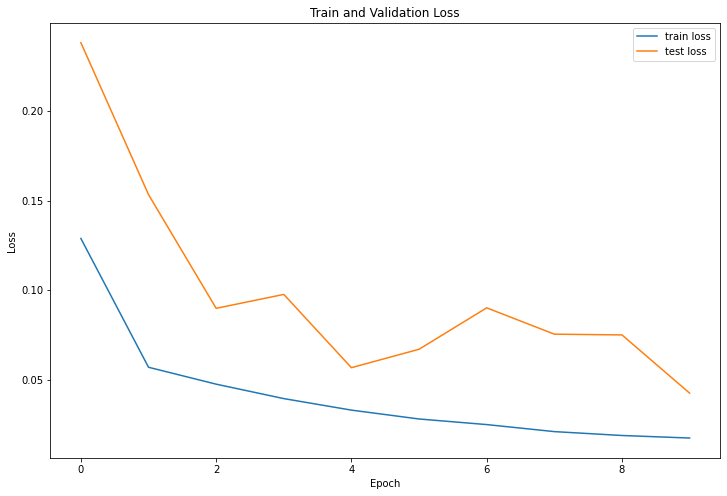

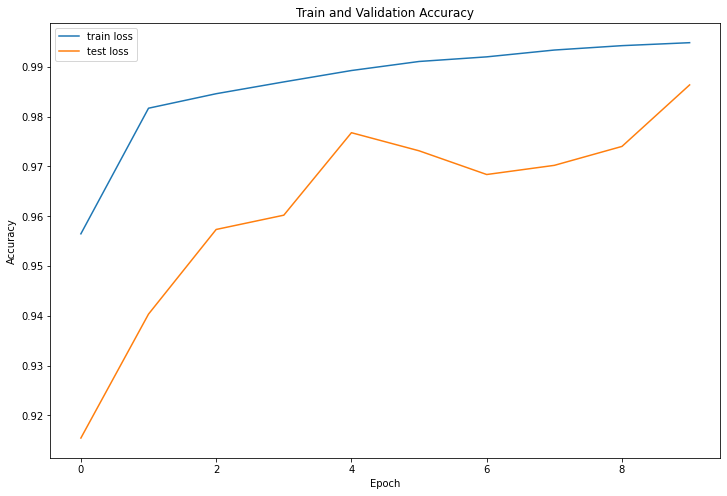

In [9]:
import matplotlib.pyplot as plt

best_model_result_df = result.trial_dataframes[result.get_best_logdir("val_loss", "min", "last")]

fig1 = plt.figure(figsize=(12, 8))
plt.plot(best_model_result_df['train_loss'].tolist(), label='train loss')
plt.plot(best_model_result_df['val_loss'].tolist(), label='test loss')
plt.title("Train and Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

fig2 = plt.figure(figsize=(12, 8))
plt.plot(best_model_result_df['train_accuracy'].tolist(), label='train loss')
plt.plot(best_model_result_df['val_accuracy'].tolist(), label='test loss')
plt.title("Train and Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()